In [2]:
!pip install smdebug matplotlib

     |████████████████████████████████| 11.5 MB 30.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 56.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.


# Amazon SageMaker Debugger Tutorial: How to Use the Built-in Debugging Rules

[Amazon SageMaker Debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html) is a feature that offers capability to debug training jobs of your machine learning model and identify training problems in real time. While a training job looks like it's working like a charm, the model might have some common problems, such as loss not decreasing, overfitting, and underfitting. To better understand, practitioners have to debug the training job, while it can be challenging to track and analyze all of the output tensors.

SageMaker Debugger covers the major deep learning frameworks (TensorFlow, PyTorch, and MXNet) and machine learning algorithm (XGBoost) to do the debugging jobs with minimal coding. Debugger provides an automatic detection of training problems through its built-in rules, and you can find a full list of the built-in rules for debugging at [List of Debugger Built-in Rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html). 

In this tutorial, you will learn how to use SageMaker Debugger and its built-in rules to debug your model.

The workflow is as follows:
* [Step 1: Import SageMaker Python SDK and the Debugger client library smdebug](#step1)
* [Step 2: Create a Debugger built-in rule list object](#step2)
* [Step 3: Construct a SageMaker estimator](#step3)
* [Step 4: Run the training job](#step4)
* [Step 5: Check training progress on Studio Debugger insights dashboard and the built-in rules evaluation status](#step5)
* [Step 6: Create a Debugger trial object to access the saved tensors](#step6)

<a class="anchor" id="step2"></a>
## Step 1: Import SageMaker Python SDK and the SMDebug client library

<font color='red'>**Important**</font>: To use the new Debugger features, you need to upgrade the SageMaker Python SDK and the SMDebug libary. In the following cell, change the third line to `install_needed=True` and run to upgrade the libraries.

In [3]:
import sys
import IPython
install_needed = False  # Set to True to upgrade
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U smdebug
    IPython.Application.instance().kernel.do_shutdown(True)

Check the SageMaker Python SDK and the SMDebug library versions.

In [4]:
import sagemaker

sagemaker.__version__

'2.29.0'

In [5]:
import smdebug

smdebug.__version__

'0.9.3'

<a class="anchor" id="step1"></a>
## Step 2: Create a Debugger built-in rule list object

In [13]:
from sagemaker.debugger import (Rule, ProfilerRule,ProfilerConfig,
    FrameworkProfile,
    DetailedProfilingConfig,
    DataloaderProfilingConfig,
    PythonProfilingConfig,
)

The following code cell shows how to configure a rule object for debugging and profiling. For more information about the Debugger built-in rules, see [List of Debugger Built-in Rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html).

In [14]:
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(
        local_path="/opt/ml/output/profiler/",
        detailed_profiling_config=DetailedProfilingConfig(start_step=5, num_steps=3),
        dataloader_profiling_config=DataloaderProfilingConfig(start_step=5, num_steps=2),
        python_profiling_config=PythonProfilingConfig(start_step=9, num_steps=1),
    ),
)
built_in_rules = [
    Rule.sagemaker(rule_configs.overfit()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

<a class="anchor" id="step3"></a>
## Step 3: Construct a SageMaker estimator

Using the rule object created in the previous cell, construct a SageMaker estimator. 

The estimator can be one of the SageMaker framework estimators, [TensorFlow](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator), [PyTorch](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html), [MXNet](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html#mxnet-estimator), and [XGBoost](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/xgboost.html), or the [SageMaker generic estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator). For more information about what framework versions are supported, see [Debugger-supported Frameworks and Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html#debugger-supported-aws-containers).

In this tutorial, the SageMaker TensorFlow estimator is constructed to run a TensorFlow training script with the Keras ResNet50 model and the cifar10 dataset.

In [15]:
import boto3
from sagemaker.tensorflow import TensorFlow

session = boto3.session.Session()
region = session.region_name

estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.8xlarge",
    image_uri=f"763104351884.dkr.ecr.{region}.amazonaws.com/tensorflow-training:2.3.1-gpu-py37-cu110-ubuntu18.04",
    # framework_version='2.3.1',
    # py_version="py37",
    max_run=3600,
    source_dir="./src",
    entry_point="tf-resnet50-cifar10.py",
    # Debugger Parameters
    rules=built_in_rules,
    profiler_config=profiler_config
)

<a class="anchor" id="step4"></a>
## Step 4: Run the training job
With the `wait=False` option, you can proceed to the next notebook cell without waiting for the training job logs to be printed out.

In [17]:
estimator.fit(wait=True)

2022-01-25 06:16:38 Starting - Starting the training job...
2022-01-25 06:17:01 Starting - Launching requested ML instancesOverfit: InProgress
ProfilerReport: InProgress
.........
2022-01-25 06:18:32 Starting - Preparing the instances for training......
2022-01-25 06:19:36 Downloading - Downloading input data
2022-01-25 06:19:36 Training - Downloading the training image.....................
2022-01-25 06:23:03 Training - Training image download completed. Training in progress..2022-01-25 06:23:04.043730: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-01-25 06:23:04.047774: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 1
2022-01-25 06:23:04.048269: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2022-01-25 06:23:04.048291: I tensorflow/core/profiler/internal/smprofi

<a class="anchor" id="step5"></a>
## Step 5: Check training progress on Studio Debugger insights dashboard and the built-in rules evaluation status

- **Option 1** - Use SageMaker Studio Debugger insights and Experiments. This is a non-coding approach.
- **Option 2** - Use the following code cells. This is a code-based approach. 

#### Option 1 - Open Studio Debugger insights dashboard to get insights into the training job

Through the Debugger insights dashboard on Studio, you can check the training jobs status, system resource utilization, and suggestions to optimize model performance. The following screenshot shows the Debugger insights dashboard interface.

<IMG src=images/studio-debugger-insights-dashboard.png/>

The following heatmap shows the `ml.p3.8xlarge` instance utilization while the training job is running or after the job has completed. To learn how to access the Debugger insights dashboard, see [Debugger on Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-on-studio.html) in the [SageMaker Debugger developer guide](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html).

<IMG src=images/studio-debugger-insights-heatmap.png/>

#### Option 2 - Run the following scripts for the code-based option

The following two code cells return the current training job name, status, and the rule status in real time.

##### Print the training job name

In [18]:
job_name = estimator.latest_training_job.name
print("Training job name: {}".format(job_name))

Training job name: tensorflow-training-2022-01-25-06-16-37-714


##### Print the training job and rule evaluation status

The following script returns the status in real time every 15 seconds, until the secondary training status turns to one of the descriptions, `Training`, `Stopped`, `Completed`, or `Failed`. Once the training job status turns into the `Training`, you will be able to retrieve tensors from the default S3 bucket.

In [19]:
import time

client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
if description["TrainingJobStatus"] != "Completed":
    while description["SecondaryStatus"] not in {"Training", "Stopped", "Completed", "Failed"}:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description["TrainingJobStatus"]
        secondary_status = description["SecondaryStatus"]
        print(
            "Current job status: [PrimaryStatus: {}, SecondaryStatus: {}] | {} Rule Evaluation Status: {}".format(
                primary_status,
                secondary_status,
                estimator.latest_training_job.rule_job_summary()[0]["RuleConfigurationName"],
                estimator.latest_training_job.rule_job_summary()[0]["RuleEvaluationStatus"],
            )
        )
        time.sleep(30)

<a class="anchor" id="step6"></a>
## Step 6: Create a Debugger trial object to access the saved model parameters

To access the saved tensors by Debugger, use the `smdebug` client library to create a Debugger trial object. The following code cell sets up a `tutorial_trial` object, and waits until it finds available tensors from the default S3 bucket.

In [20]:
from smdebug.trials import create_trial

tutorial_trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-01-25 06:33:55.991 tensorflow-2-1-cpu-py-ml-t3-medium-5412cd1de9a68eef8b9e1e29c67d:40 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-524966505555/tensorflow-training-2022-01-25-06-16-37-714/debug-output


The Debugger trial object accesses the SageMaker estimator's Debugger artifact path, and fetches the output tensors saved for debugging.

#### Print the default S3 bucket URI where the Debugger output tensors are stored

In [21]:
tutorial_trial.path

's3://sagemaker-us-east-1-524966505555/tensorflow-training-2022-01-25-06-16-37-714/debug-output/'

#### Print the Debugger output tensor names

In [22]:
tutorial_trial.tensor_names()

[2022-01-25 06:33:57.571 tensorflow-2-1-cpu-py-ml-t3-medium-5412cd1de9a68eef8b9e1e29c67d:40 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-25 06:33:58.603 tensorflow-2-1-cpu-py-ml-t3-medium-5412cd1de9a68eef8b9e1e29c67d:40 INFO trial.py:210] Loaded all steps


['accuracy', 'batch', 'loss', 'val_accuracy', 'val_loss']

#### Print the list of steps where the tensors are saved

The smdebug `ModeKeys` class provides training phase mode keys that you can use to sort training (`TRAIN`) and validation (`EVAL`) steps and their corresponding values.

In [23]:
from smdebug.core.modes import ModeKeys

In [24]:
tutorial_trial.steps(mode=ModeKeys.TRAIN)

[0,
 500,
 1000,
 1500,
 2000,
 2500,
 3000,
 3500,
 4000,
 4500,
 5000,
 5500,
 6000,
 6500,
 7000,
 7500]

In [25]:
tutorial_trial.steps(mode=ModeKeys.EVAL)

[0, 312, 500, 625, 938, 1000, 1251, 1500, 1564]

#### Plot the loss curve

The following script plots the loss and accuracy curves of training and validation loops.

In [26]:
trial = tutorial_trial


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

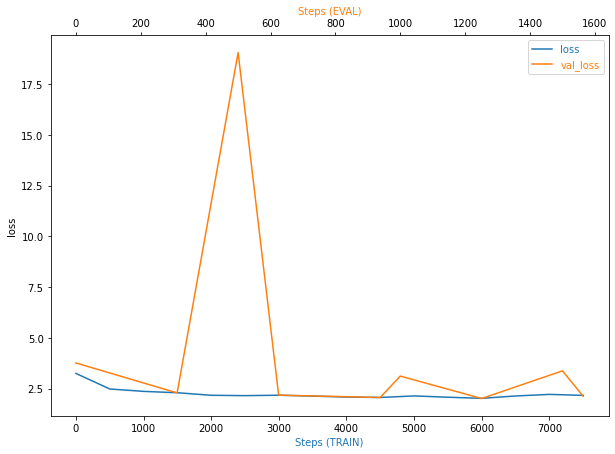

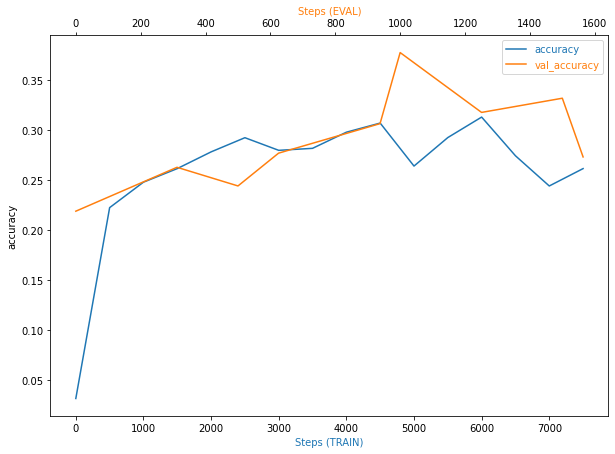

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    tensor_name = tensor_name
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)

    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()


plot_tensor(trial, "loss")
plot_tensor(trial, "accuracy")

> ## Note : Rerun the above cell if you don't see any plots! 

## Conclusion

In this tutorial, you learned how to use SageMaker Debugger with the minimal coding through SageMaker Studio and Jupyter notebook. The Debugger built-in rules detect training anomalies while concurrently reading in the output tensors, such as weights, activation outputs, gradients, accuracy, and loss, from your training jobs. In the next tutorial videos, you will learn more features of Debugger, such as how to analyze the tensors, change the built-in debugging rule parameters and thresholds, and save the tensors at your preferred S3 bucket URI.